[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/LogisticRegression.ipynb)


# Logistic Regression
In logistic regression we perform binary classification of by learnig a function of the form $f_w(x) = \sigma(x^\top w)$. Here $x,w \in \mathbb{R}^D$, where $D$ is the number of features as before. $\sigma(z) = \frac{1}{1+e^{-z}}$ is the logistic function.  Let's plot this function below

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

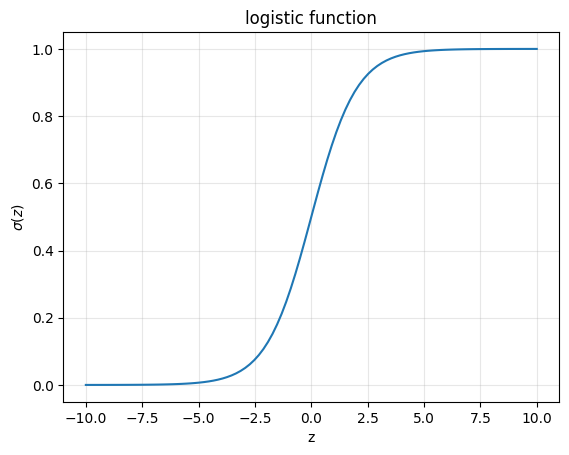

In [2]:
# Define the logistic (sigmoid) function
# Maps any real number to the range (0, 1)
# Used to convert raw predictions to probabilities
logistic = lambda z: 1. / (1 + np.exp(-z))

# Create values from -10 to 10 for visualization
z = np.linspace(-10, 10, 100)

# Plot the S-shaped logistic curve
plt.plot(z, logistic(z))
plt.xlabel('z')
plt.ylabel(r'$\sigma(z)$')
plt.title('logistic function')
plt.grid(True, alpha=0.3)
plt.show()

In [3]:
# Shape reference guide for logistic regression and softmax
# This cell documents array shapes - helps when debugging dimension mismatches

# Binary classification (logistic regression):
# x [N,D]              - N samples, D features
# w [D]                - D weights (one per feature)
# x@w [N]              - raw predictions (logits) for N samples
# logistic(x@w) [N]    - probabilities in range (0,1) for N samples

# Multi-class classification (softmax regression):
# x [N,D]              - N samples, D features, mapping R^D -> R^C
# w [D,C]              - weights matrix, D features to C classes
# logits = x@w [N,C]   - raw predictions for N samples, C classes
# Numerical stability trick (prevents overflow):
# logits = logits - np.max(logits, axis=1, keepdims=True)
# Softmax formula (converts logits to probabilities):
# softmax[j,i] = exp(logits[j,i]) / (np.sum(exp(logits[j,:]), axis=1) + eps)
# softmax(x@w) [N,C]   - class probabilities for N samples, C classes

## Cost function
To fit our model $f_w$ to the data $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, we maximize the **logarithm of the conditional likelihood**:

$$
\ell(w; \mathcal{D}) = \sum_n \log \mathrm{Bernoulli}(y^{(n)} | \sigma({x^{(n)}}^\top w)) = \sum_n y^{(n)} \log \sigma({x^{(n)}}^\top w)) + (1-y^{(n)}) \log (1-\sigma({x^{(n)}}^\top w)))
$$

by substituting the definition of logistic function in the equation above, and minimizing the **negative** of the log-likelihood, which is called the **cost function**,
we get

$$
J(w) = \sum_n y^{(n)} \log(1+e^{-x w^\top}) + (1-y^{(n)}) \log(1+e^{x w^\top})
$$

In practice we use mean rather than sum over data points.

In [4]:
def cost_fn(x, y, w):
    """
    Compute the binary cross-entropy cost (negative log-likelihood).
    
    Parameters:
    x: input features, shape (N, D)
    y: binary labels (0 or 1), shape (N,)
    w: weights, shape (D,)
    
    Returns:
    J: scalar cost value (lower is better)
    """
    N, D = x.shape
    
    # Compute logits: z = x @ w, shape (N,)
    # These are the raw predictions before applying sigmoid
    z = np.dot(x, w)
    
    # Binary cross-entropy loss (mean over all samples)
    # np.log1p(x) computes log(1 + x) with better numerical stability
    # For y=1: cost is log(1 + exp(-z)) which penalizes z being too negative
    # For y=0: cost is log(1 + exp(z)) which penalizes z being too positive
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))
    
    return J

## Minimizing the cost using gradient descent
To minimize the cost we use gradient descent: start from some initial assignment to the parameters $w$, and at each iteration take a small step in the opposite direction of the *gradient*. The gradient of the cost function above is given by:

$$
\frac{\partial}{\partial w_d} J(w) =\sum_n - y^{(n)} x^{(n)}_d \frac{e^{-w^\top x^{(n)}}}{1 + e^{-w^\top x^{(n)}}} +x^{(n)}_d (1- y^{(n)}) \frac{e^{w^\top x^{(n)}}}{1 + e^{w^\top x^{(n)}}} = \sum_n - x^{(n)}_d y^{(n)} (1-\hat{y}^{(n)})+ x^{(n)}_d (1- y^{(n)}) \hat{y}^{(n)} = x^{(n)}_d (\hat{y}^{(n)} - y^{(n)}) 
$$
Since in practice we divide the cost by $N$, we have to the same for the gradient; see the implementation below.

In [5]:
def gradient(self, x, y):
    """
    Compute the gradient of the cost function with respect to weights.
    
    The gradient tells us how to adjust weights to reduce the cost.
    
    Parameters:
    x: input features, shape (N, D)
    y: true binary labels, shape (N,)
    
    Returns:
    grad: gradient vector, shape (D,)
    """
    N, D = x.shape
    
    # Compute predictions using current weights
    # yh = σ(x @ w), shape (N,)
    # These are predicted probabilities in range (0, 1)
    yh = logistic(np.dot(x, self.w))
    
    # Compute gradient: x^T @ (yh - y) / N
    # x.T is (D, N), (yh - y) is (N,)
    # Result is (D,) - one gradient value per weight
    # Division by N because we use mean (not sum) in the cost function
    # Positive gradient means increasing that weight would increase cost
    grad = np.dot(x.T, yh - y) / N
    
    return grad

## Logistic regression class
Now we are ready to implement the logistic regression class with the usual `fit` and `predict` methods. Here, the `fit` method implements gradient descent.

In [6]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        """
        Initialize Logistic Regression classifier.
        
        Parameters:
        add_bias: if True, adds an intercept term to the model
        learning_rate: step size for gradient descent (also called alpha)
        epsilon: convergence threshold - stop when ||gradient|| < epsilon
        max_iters: maximum number of gradient descent iterations
        verbose: if True, print optimization progress
        """
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.verbose = verbose
        
    def fit(self, x, y):
        """
        Fit the logistic regression model using gradient descent.
        
        Parameters:
        x: input features, shape (N,) or (N, D)
        y: binary labels (0 or 1), shape (N,)
        
        Returns:
        self: fitted model
        """
        # If x is 1D, convert to 2D column vector
        # x[:, None] adds a new axis: (N,) -> (N, 1)
        if x.ndim == 1:
            x = x[:, None]
        
        if self.add_bias:
            N = x.shape[0]
            # Add bias feature: append a column of ones
            # x goes from (N, D) to (N, D+1)
            x = np.column_stack([x, np.ones(N)])
        
        N, D = x.shape
        
        # Initialize weights to zero
        self.w = np.zeros(D)
        
        # Initialize gradient norm to infinity (ensures loop starts)
        g = np.inf
        
        # Iteration counter
        t = 0
        
        # Gradient descent loop
        # Stop when: (1) gradient is small enough, OR (2) max iterations reached
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            # Compute gradient at current weights
            g = self.gradient(x, y)
            
            # Update weights: move in opposite direction of gradient
            # w_new = w_old - learning_rate * gradient
            # This moves "downhill" on the cost surface
            self.w = self.w - self.learning_rate * g
            
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g):.6f}')
            print(f'the weight found: {self.w}')
        
        return self
    
    def predict(self, x):
        """
        Predict class probabilities for input x.
        
        Parameters:
        x: input features, shape (N,) or (N, D)
        
        Returns:
        yh: predicted probabilities P(y=1|x), shape (N,)
        """
        # Convert 1D to 2D if needed
        if x.ndim == 1:
            x = x[:, None]
        
        Nt = x.shape[0]
        
        if self.add_bias:
            # Add bias feature column
            x = np.column_stack([x, np.ones(Nt)])
        
        # Compute probabilities: σ(x @ w)
        # Output is in range (0, 1)
        yh = logistic(np.dot(x, self.w))
        
        return yh

# Attach the gradient method to the LogisticRegression class
# This allows self.gradient(x, y) to work inside the fit method
LogisticRegression.gradient = gradient

## Toy experiment

fit this linear model to toy data with $x \in \Re^1$ + a bias parameter

terminated after 100000 iterations, with norm of the gradient equal to 0.000789
the weight found: [-9.96926826 20.27319341]


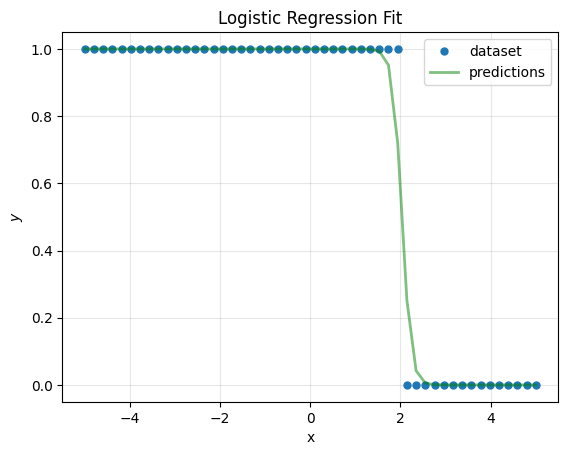

In [7]:
N = 50

# Create evenly spaced x values from -5 to 5
x = np.linspace(-5, 5, N)

# Create binary labels: y=1 when x < 2, y=0 otherwise
# This creates a step function at x=2
# astype(int) converts boolean array to 0s and 1s
y = (x < 2).astype(int)

# Fit the logistic regression model
model = LogisticRegression(verbose=True)
yh = model.fit(x, y).predict(x)

# Plot the data and predicted probabilities
plt.plot(x, y, '.', label='dataset', markersize=10)
plt.plot(x, yh, 'g', alpha=.5, linewidth=2, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.title('Logistic Regression Fit')
plt.grid(True, alpha=0.3)
plt.show()

we see that the model successfully fits the training data. If we run the optimization for long enough the weights will grow large (in absolute value) so as to make the predicted probabilities for the data-points close to the decidion boundary (x=2) close to zero and one.


## Weight Space
Similar to what we did for linear regression, we plot *cost* as a function for logistic regrression as a function of model parameters (weights), and show the correspondence between the different weights having different costs and their fit. 
The `plot_contour` is the same helper function we used for plotting the cost function for linear regression.

In [8]:
import itertools

def plot_contour(f, x1bound, x2bound, resolution, ax):
    """
    Plot contours of a 2D cost function.
    
    Parameters:
    f: function that takes [w0, w1] and returns a scalar (the cost)
    x1bound: [min, max] for first parameter
    x2bound: [min, max] for second parameter
    resolution: number of grid points in each dimension
    ax: matplotlib axis to plot on
    """
    # Create 1D arrays of evenly spaced values for each parameter
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    
    # Create 2D grid of parameter combinations
    # xg[i,j] and yg[i,j] give the coordinates of grid point (i,j)
    xg, yg = np.meshgrid(x1range, x2range)
    
    # Initialize array to store cost values
    zg = np.zeros_like(xg)
    
    # Evaluate cost at each grid point
    for i, j in itertools.product(range(resolution), range(resolution)):
        zg[i, j] = f([xg[i, j], yg[i, j]])
    
    # Draw contour lines (lines of equal cost)
    ax.contour(xg, yg, zg, 100)
    
    return ax

Now let's define the cost function for linear regression example above, and visualize the cost and the fit of various models (parameters).

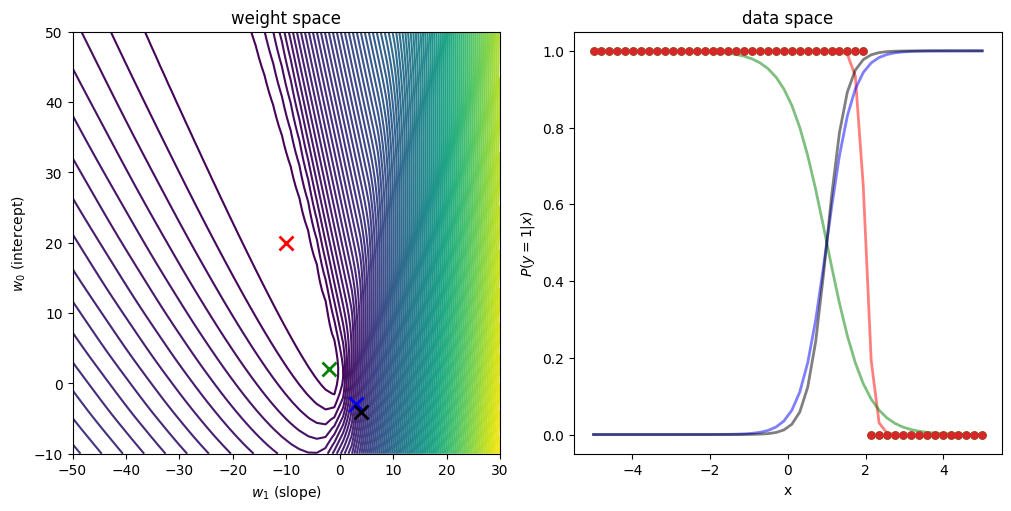

In [9]:
# Prepare data with bias term for cost function visualization
# Add a column of ones to x for the bias/intercept term
# x_plus_bias has shape (N, 2): first column is x, second column is ones
x_plus_bias = np.column_stack([x, np.ones(x.shape[0])])

# Define cost as a function of parameters only (x and y are fixed)
# param[0] is w_1 (weight for x), param[1] is w_0 (bias/intercept)
cost_w = lambda param: cost_fn(x_plus_bias, y, param)

# Different weight combinations to visualize
# Each tuple is (w_1, w_0)
model_list = [(-10, 20), (-2, 2), (3, -3), (4, -4)]

# Create side-by-side plots
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 5))

# Left plot: visualize the cost landscape in weight space
plot_contour(cost_w, [-50, 30], [-10, 50], 50, axes[0])

colors = ['r', 'g', 'b', 'k']

# Plot each weight combination in both spaces
for i, w in enumerate(model_list):
    # Left plot: mark this weight combination with an 'x'
    axes[0].plot(w[0], w[1], 'x'+colors[i], markersize=10, markeredgewidth=2)
    
    # Right plot: show the data points
    axes[1].plot(x, y, '.', markersize=10)
    
    # Right plot: show the decision boundary for this weight combination
    # Compute σ(w_0 + w_1*x) to get predicted probabilities
    # Note: order is w[1] (intercept) + w[0] (slope) * x
    axes[1].plot(x, logistic(w[1] + np.dot(w[0], x)), '-'+colors[i], alpha=.5, linewidth=2)

# Label the plots
axes[0].set_xlabel(r'$w_1$ (slope)')
axes[0].set_ylabel(r'$w_0$ (intercept)')
axes[0].set_title('weight space')
axes[1].set_xlabel('x')
axes[1].set_ylabel(r'$P(y=1|x)$')
axes[1].set_title('data space')
plt.show()

## Iris dataset
Let's visualize class probabilities for D=2 (plus a bias). 
To be able to use logistic regression we choose two of the three classes in the Iris dataset.

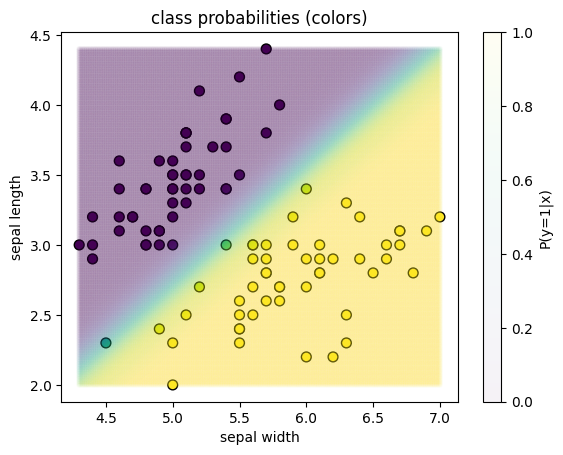

In [10]:
from sklearn import datasets

# Load the famous Iris dataset
dataset = datasets.load_iris()

# Extract only the first 2 features (sepal length and width)
# dataset['data'] has shape (150, 4), we take only columns 0 and 1
# dataset['target'] contains class labels: 0, 1, or 2
x, y = dataset['data'][:, :2], dataset['target']

# Keep only classes 0 and 1 (remove class 2)
# This makes it a binary classification problem
# y < 2 creates a boolean mask: [True, True, ..., False, False]
# x[y < 2] selects only rows where the mask is True
x, y = x[y < 2], y[y < 2]

# Fit logistic regression model
model = LogisticRegression()
yh = model.fit(x, y).predict(x)

# Create a dense grid of points to visualize decision boundary
# Covers the entire range of the data
x0v = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 200)
x1v = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 200)

# Create 2D mesh grid
# x0 and x1 are both (200, 200) arrays
x0, x1 = np.meshgrid(x0v, x1v)

# Flatten and stack to create array of all grid points
# ravel() flattens (200, 200) -> (40000,)
# vstack stacks vertically, then transpose to get (40000, 2)
# Each row is a point [x0, x1] in the 2D feature space
x_all = np.vstack((x0.ravel(), x1.ravel())).T

# Predict probabilities for all grid points
yh_all = model.predict(x_all)

# Plot: color shows predicted probability P(y=1|x)
# Training data points (larger circles, opaque)
plt.scatter(x[:, 0], x[:, 1], c=yh, marker='o', alpha=1, s=50, edgecolors='black')

# Background grid points (small dots, transparent) show decision boundary
# The boundary is where yh_all ≈ 0.5 (transition from class 0 to class 1)
plt.scatter(x_all[:, 0], x_all[:, 1], c=yh_all, marker='.', alpha=.05)

plt.xlabel('sepal width')
plt.ylabel('sepal length')
plt.title('class probabilities (colors)')
plt.colorbar(label='P(y=1|x)')
plt.show()